# Creating a Scalable Recommender with Apache Spark & Elasticsearch

In this notebook, you will create a recommendation engine using Spark and Elasticsearch. Using some movie rating data,
you will train a collaborative filtering model in Spark and export the trained model to Elasticsearch. Once exported, 
you can test your recommendations by querying Elasticsearch and displaying the results.

### _Prerequisites_

The notebook assumes you have installed Elasticsearch, Apache Spark and the Elasticsearch Spark connector detailed in the [setup steps](https://github.com/IBM/elasticsearch-spark-recommender/tree/master#steps).

> _Optional:_

> In order to display the images in the recommendation demo, you will need to access [The Movie Database (TMdb) API](https://www.themoviedb.org/documentation/api). Please follow the [instructions](https://developers.themoviedb.org/3/getting-started) to get an API key.

## Overview

You will work through the following steps

1. Prepare the data
2. Use the Elasticsearch Spark connector to save it to Elasticsearch
3. Load ratings data and train a collaborative filtering recommendation model using Spark MLlib
3. Save the model to Elasticsearch
4. Show recommendations using Elasticsearch's script score query together with vector functions

## Step 1: Prepare the data

* This notebook uses the "small" version of the latest MovieLens movie rating dataset, containing about 100,000 ratings, 9,000 movies and 700 users
* The latest version of the data can be downloaded at https://grouplens.org/datasets/movielens/latest/
* Follow the [Code Pattern instructions](https://github.com/IBM/elasticsearch-spark-recommender/tree/master#5-download-the-data) to download the `ml-latest-small.zip` file and unzip it to a suitable location on your system.

The folder should contain a number of CSV files. We will be using the following files:
* `ratings.csv` - movie rating data
* `links.csv` - external database ids for each movie
* `movies.csv` - movie title and genres

In [1]:
# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('thanhtruong').master('local[*]').getOrCreate()

### Load rating and movie data

**Ratings**

The ratings data consists of around 100,000 ratings given by users to movies. Each row of the `DataFrame` consists of a `userId`, `movieId` and `timestamp` for the event, together with the `rating` given by the user to the movie

In [2]:
PATH_TO_DATA = "../data/ml-latest-small"
# load ratings data
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Number of ratings: {}".format(ratings.count()))
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 100836
Sample of ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



You will see that the `timestamp` field is a UNIX timestamp in seconds. Elasticsearch takes timestamps in milliseconds, so you will use some `DataFrame` operations to convert the timestamps into milliseconds.

In [3]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



**Movies**

The file `movies.csv` contains the `movieId`, `title` and `genres` for each movie. As you can see, the `genres` field is a bit tricky to use, as the genres are in the form of one string delimited by the `|` character: `Adventure|Animation|Children|Comedy|Fantasy`.

In [4]:
# load raw data from CSV
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



For indexing into Elasticsearch, we would prefer to represent the genres as a list. Create a `DataFrame` user-defined function (UDF) to extract this delimited string into a list of genres.

In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import os
import sys
from pyspark import SparkContext
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Định nghĩa một UDF để chuyển đổi chuỗi genres thành một mảng genres viết thường
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))

# Sử dụng UDF để chuyển đổi cột "genres" và chọn cột "movieId" và "title"
# Đặt tên cột mới là "genres"
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



Ok, that looks better!

You may also notice that the movie titles contain the year of release. It would be useful to have that as a field in your search index for filtering results (say you want to filter our recommendations to include only more recent movies).

Create a UDF to extract the release year from the title using a Python regular expression.

In [6]:
import re
from pyspark.sql.types import StringType, StructType, StructField
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn, StructType([StructField("title", StringType(), True),StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Ok the function works! Now create a new `DataFrame` with the cleaned-up titles, release dates and genres of the movies.

In [7]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:


+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



Next, join the `links.csv` data to `movies` so that there is an id for _The Movie Database_ corresponding to each movie. You can use this id to retrieve movie poster images when displaying your recommendations later.

In [8]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print(num_movies)
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

9742
Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+-------------------------------------------

> **_Optional_**
>
> Run the below cell to test your access to TMDb API. You should see the _Toy Story_ movie poster displayed inline.
>
> To install the Python package run `pip install tmdbsimple` in your console (see the [Code Pattern Steps](https://github.com/IBM/elasticsearch-spark-recommender/tree/master#6-launch-the-notebook))

Successfully imported tmdbsimple!


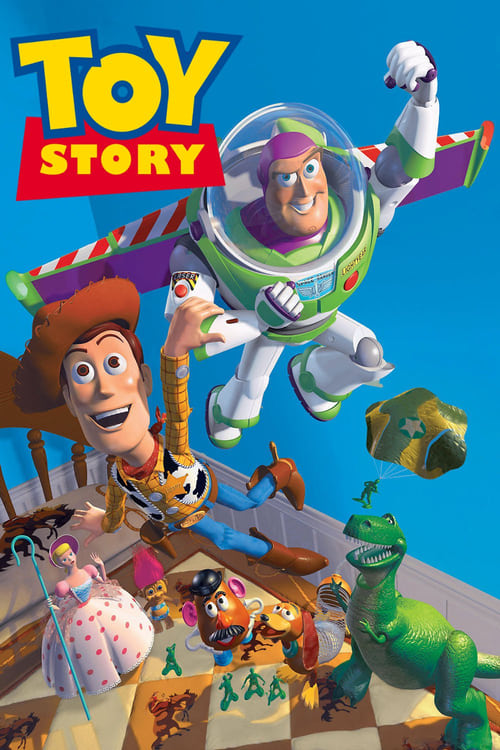

In [9]:
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = 'd991c0846837eea6cb0709bd3a8440bb'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))

## Step 2: Load data into Elasticsearch

Now that you have your dataset processed and prepared, you will load it into Elasticsearch.

_Note:_ for the purposes of this demo notebook you have started with an existing example dataset and will load that into Elasticsearch. In practice you may write your event data as well as user and item metadata from your application directly into Elasticsearch.

First test that your Elasticsearch instance is running and you can connect to it using the Python Elasticsearch client.

In [10]:
from elasticsearch import Elasticsearch

# Cung cấp đầy đủ thông tin cấu hình, bao gồm scheme, host và port
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Test kết nối
es.info(pretty=True)


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\1722278696.py:7: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  es.info(pretty=True)


ObjectApiResponse({'name': 'DESKTOP-TQ54SGR', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'Ql1sS42ORTevLiDTLR5PoQ', 'version': {'number': '7.15.2', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': '93d5a7f6192e8a1a12e154a2b81bf6fa7309da0c', 'build_date': '2021-11-04T14:04:42.515624022Z', 'build_snapshot': False, 'lucene_version': '8.9.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'})

### Create Elasticsearch indices, with mappings for users, movies and rating events

In Elasticsearch, an "index" is roughly similar to a "database" or "database table". The schema for an index is called an index mapping.

While Elasticsearch supports dynamic mapping, it's advisable to specify the mapping explicitly when creating an index if you know what your data looks like.

For the purposes of your recommendation engine, this is also necessary so that you can specify the vector field that will hold the recommendation "model" (that is, the factor vectors). When creating a vector field, you need to provide the dimension of the vector explicitly, so it cannot be a dynamic mapping.

> _Note_ This notebook does not go into detail about the underlying scoring mechanism or the relevant Elasticsearch internals. See the talks and slides in the [Code Pattern Links section](https://github.com/IBM/elasticsearch-spark-recommender/blob/master/README.md#links) for more detail.

__References:__
* [Create index API](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Index mapping](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html)
* [Dense vector types](https://www.elastic.co/guide/en/elasticsearch/reference/current/dense-vector.html)

> **_Optional_**

> If you are re-running the notebook and have previously created the `movies`, `users` and `ratings`indices in Elasticsearch, you should first delete them by un-commenting and running the next cell, before running the index creation cell that follows.

In [ ]:
# index_name = "users"

# # Kiểm tra xem index đã tồn tại chưa
# if es.indices.exists(index=index_name):
#     # Xóa index nếu nó tồn tại
#     es.indices.delete(index=index_name)
#     print(f"Đã xóa index '{index_name}'.")
# else:
#     print(f"Index '{index_name}' không tồn tại.")

Đã xóa index 'users'.


Now you're ready to create your indices.

In [ ]:
# set the factor vector dimension for the recommendation model
VECTOR_DIM = 20

create_ratings = {
    # this mapping definition sets up the fields for the rating events
    "mappings": {
        "properties": {
            "timestamp": {
                "type": "date"
            },
            "userId": {
                "type": "integer"
            },
            "movieId": {
                "type": "integer"
            },
            "rating": {
                "type": "double"
            }
        }  
    }
}

create_users = {
    # this mapping definition sets up the metadata fields for the users
    "mappings": {
        "properties": {
            "userId": {
                "type": "integer"
            },
            # the following fields define our model factor vectors and metadata
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }
        }
    }
}

create_movies = {
    # this mapping definition sets up the metadata fields for the movies
    "mappings": {
        "properties": {
            "movieId": {
                "type": "integer"
            },
            "tmdbId": {
                "type": "keyword"
            },
            "genres": {
                "type": "keyword"
            },
            "release_date": {
                "type": "date",
                "format": "year"
            },
            # the following fields define our model factor vectors and metadata
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }          
        }
    }
}

# # create indices with the settings and mappings above
# res_ratings = es.indices.create(index="ratings", body=create_ratings)
# res_users = es.indices.create(index="users", body=create_users)
# res_movies = es.indices.create(index="movies", body=create_movies)

# print("Created indices:")
# print(res_ratings)
# print(res_users)
# print(res_movies)

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_712\3724155424.py:79: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  res_ratings = es.indices.create(index="ratings", body=create_ratings)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_712\3724155424.py:80: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  res_users = es.indices.create(index="users", body=create_users)


Created indices:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'ratings'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'users'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'movies'}


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_712\3724155424.py:81: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  res_movies = es.indices.create(index="movies", body=create_movies)


### Load Ratings and Movies DataFrames into Elasticsearch

First you will write the ratings data to Elasticsearch. Notice that you can simply use the Spark Elasticsearch connector to write a `DataFrame` with the native Spark datasource API by specifying `format("es")`

In [12]:

def json_formatter(dataset, index_name, index_type='_doc'):
    try:
        List = []
        columns = dataset.columns
        for row in dataset.rdd.collect():
            dic = {}
            dic['_index'] = index_name
            dic['_type'] = index_type
            source = {}
            for i, col in enumerate(columns):
                source[col] = row[i]
            dic['_source'] = source
            List.append(dic)
        return List
    
    except Exception as e:
        print("There is a problem: {}".format(e))


In [13]:
json_Formatted_ratings = json_formatter(dataset=ratings, index_name='ratings', index_type='_doc')
json_Formatted_ratings[0]

{'_index': 'ratings',
 '_type': '_doc',
 '_source': {'userId': 1,
  'movieId': 1,
  'rating': 4.0,
  'timestamp': 964982703000}}

In [15]:
from elasticsearch import helpers
try:
    res = helpers.bulk(es, json_Formatted_ratings)
    print("successfully imported to elasticsearch.")
except Exception as e:
    print(f"error: {e}")

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5580\2253164446.py:3: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  res = helpers.bulk(es, json_Formatted_ratings)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5580\2253164446.py:3: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  res = helpers.bulk(es, json_Formatted_ratings)


successfully imported to elasticsearch.


Các bước trên là tạo index trong elasticsearch và đẩy dữ liệu lên nhưng em đã tạo index và đẩy lên rồi nên em không chạy nữa mà em sẽ chạy phần dưới để kiểm tra xem index đã có dữ liệu chưa

In [11]:
# test things out by retrieving a few rating event documents from Elasticsearch
es.search(index="ratings", q="*", size=3)

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\2322905500.py:2: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  es.search(index="ratings", q="*", size=3)


ObjectApiResponse({'took': 2, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'ratings', '_type': '_doc', '_id': '2sIQn4sB5q04Oul4AlfG', '_score': 1.0, '_source': {'userId': 1, 'movieId': 1, 'rating': 4.0, 'timestamp': 964982703000}}, {'_index': 'ratings', '_type': '_doc', '_id': '28IQn4sB5q04Oul4AlfK', '_score': 1.0, '_source': {'userId': 1, 'movieId': 3, 'rating': 4.0, 'timestamp': 964981247000}}, {'_index': 'ratings', '_type': '_doc', '_id': '3MIQn4sB5q04Oul4AlfK', '_score': 1.0, '_source': {'userId': 1, 'movieId': 6, 'rating': 4.0, 'timestamp': 964982224000}}]}})

Since you've indexed the rating event data into Elasticsearch, you can use all the capabilities of a search engine to query the data. For example, you could count the number of ratings events in a given date range using Elasticsearch's date math in a query string:

In [12]:
es.count(index="ratings", q="timestamp:[2018-01-01 TO 2018-02-01]")

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\1361616288.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  es.count(index="ratings", q="timestamp:[2018-01-01 TO 2018-02-01]")


ObjectApiResponse({'count': 952, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

Next write the movie metadata

In [18]:
def json_formatter_movies(dataset, index_name):
    try:
        List = []
        for row in dataset.rdd.collect():
            dic = {}
            dic['_index'] = index_name
            dic['_id'] = str(row["movieId"])  # Set trường "movieId" làm trường id
            dic['_source'] = row.asDict()
            List.append(dic)
        return List
    except Exception as e:
        print("There is a problem: {}".format(e))


In [20]:
json_Formatted_movies = json_formatter_movies(dataset=movie_data, index_name='movies')
json_Formatted_movies[0]

{'_index': 'movies',
 '_id': '1',
 '_source': {'movieId': 1,
  'title': 'Toy Story',
  'release_date': '1995',
  'genres': ['adventure', 'animation', 'children', 'comedy', 'fantasy'],
  'tmdbId': 862}}

Again you can harness the power of search to query the movie metadata:

In [104]:
from elasticsearch import helpers
try:
    res = helpers.bulk(es, json_Formatted_movies)
    print("successfully imported to elasticsearch.")
except Exception as e:
    print(f"error: {e}")

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5580\2527107742.py:3: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  res = helpers.bulk(es, json_Formatted_movies)


successfully imported to elasticsearch.


In [13]:
# test things out by searching for movies containing "matrix" in the title
es.search(index="movies", q="title:matrix", size=3)

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\1472089654.py:2: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  es.search(index="movies", q="title:matrix", size=3)


ObjectApiResponse({'took': 2, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 3, 'relation': 'eq'}, 'max_score': 9.550224, 'hits': [{'_index': 'movies', '_type': '_doc', '_id': '2571', '_score': 9.550224, '_source': {'movieId': 2571, 'title': 'Matrix, The', 'release_date': '1999', 'genres': ['action', 'sci-fi', 'thriller'], 'tmdbId': 603}}, {'_index': 'movies', '_type': '_doc', '_id': '6365', '_score': 8.322349, '_source': {'movieId': 6365, 'title': 'Matrix Reloaded, The', 'release_date': '2003', 'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'], 'tmdbId': 604}}, {'_index': 'movies', '_type': '_doc', '_id': '6934', '_score': 8.322349, '_source': {'movieId': 6934, 'title': 'Matrix Revolutions, The', 'release_date': '2003', 'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'], 'tmdbId': 605}}]}})

## Step 3: Train a recommmender model on the ratings data

Your data is now stored in Elasticsearch and you will use the ratings data to build a collaborative filtering recommendation model.

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a recommendation approach that is effectively based on the "wisdom of the crowd". It makes the assumption that, if two people share similar preferences, then the things that one of them prefers could be good recommendations to make to the other. In other words, if user A tends to like certain movies, and user B shares some of these preferences with user A, then the movies that user A likes, that user B _has not yet seen_, may well be movies that user B will also like.

In a similar manner, we can think about _items_ as being similar if they tend to be rated highly by the same people, on average. 

Hence these models are based on the combined, collaborative preferences and behavior of all users in aggregate. They tend to be very effective in practice (provided you have enough preference data to train the model). The ratings data you have is a form of _explicit preference data_, perfect for training collaborative filtering models.

### Alternating Least Squares

Alternating Least Squares (ALS) is a specific algorithm for solving a type of collaborative filtering model known as [matrix factorization (MF)](https://en.wikipedia.org/wiki/Matrix_decomposition). The core idea of MF is to represent the ratings as a _user-item ratings matrix_. In the diagram below you will see this matrix on the left (with users as _rows_ and movies as _columns_). The entries in this matrix are the ratings given by users to movies.

You may also notice that the matrix has _missing entries_ because not all users have rated all movies. In this situation we refer to the data as _sparse_.

![als-diagram.png](../doc/source/images/als-diagram.png)

MF methods aim to find two much smaller matrices (one representing the _users_ and the other the _items_) that, when multiplied together, re-construct the original ratings matrix as closely as possible. This is know as _factorizing_ the original matrix, hence the name of the technique.

The two smaller matrices are called _factor matrices_ (or _latent features_). The user and movie factor matrices are illustrated on the right in the diagram above. The idea is that each user factor vector is a compressed representation of the user's preferences and behavior. Likewise, each item factor vector is a compressed representation of the item. Once the model is trained, the factor vectors can be used to make recommendations, which is what you will do in the following sections.

__Further reading:__

* [Spark MLlib Collaborative Filtering](http://spark.apache.org/docs/latest/ml-collaborative-filtering.html)
* [Alternating Least Squares and collaborative filtering](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Quora question on Alternating Least Squares](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this)

Fortunately, Spark's MLlib machine learning library has a scalable, efficient implementation of matrix factorization built in, which we can use to train our recommendation model. Next, you will use Spark's ALS to train a model on your ratings data from Elasticsearch.

In [ ]:
ratings_from_es = spark.read.format("es").load("ratings")
ratings_from_es.show(5)

In [97]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.02, rank=20, seed=54)
model = als.fit(ratings)
model.userFactors.show(5, truncate=False)
model.itemFactors.show(5)

+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                                     |
+---+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10 |[-0.25700277, 0.48391187, 0.25251985, -0.2647092, 0.13420826, 0.8419825, 1.1884936, 0.378827, 0.72958827, -0.76125747, 0.30725777, -0.28689098, 0.4126791, 1.0684941, 0.46430388, 0.2674706, -0.47710183, -0.045865472,

## Step 4: Export ALS user and item factor vectors to Elasticsearch

Congratulations, you've trained a recommendation model! The next step is to export the model factors (shown in the `DataFrames` above) to Elasticsearch.

We can export the model factor vector directly to Elasticsearch, since it is an array and the `dense_vector` field expects an array as input.

For illustrative purposes, we will also export model metadata (such as the Spark model id and a timestamp).

### Write the model factor vectors, model version and model timestamp to Elasticsearch

In [25]:
from pyspark.sql.functions import lit, current_timestamp, unix_timestamp
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id",\
                                         col("features").alias("model_factor"),\
                                         lit(ver).alias("model_version"),\
                                         ts.alias("model_timestamp"))
movie_vectors.show(5)
user_vectors = model.userFactors.select("id",\
                                        col("features").alias("model_factor"),\
                                        lit(ver).alias("model_version"),\
                                        ts.alias("model_timestamp"))
user_vectors.show(5)

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.40706345, -0.1...|ALS_5d6e0d177a5e|     1699181258|
| 20|[0.61174625, 0.19...|ALS_5d6e0d177a5e|     1699181258|
| 30|[1.007635, 0.8495...|ALS_5d6e0d177a5e|     1699181258|
| 40|[0.35743803, -0.2...|ALS_5d6e0d177a5e|     1699181258|
| 50|[0.8544814, 0.064...|ALS_5d6e0d177a5e|     1699181258|
+---+--------------------+----------------+---------------+
only showing top 5 rows

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[-0.25700277, 0.4...|ALS_5d6e0d177a5e|     1699181258|
| 20|[-0.46377513, -2....|ALS_5d6e0d177a5e|     1699181258|
| 30|[-0.31054395, -0....|ALS_5d6e0d177a5e|     1699181258|
| 40|[0.013999048, 0.5...|ALS_5d6e0d177a5e|     1699181258|
| 50|[0.0938845

### Check the data  was written correctly

You can search for a movie to see if the model factor vector was written correctly. You should see a `'model_factor': [0..188..., ]` field in the returned movie document, as well as a `model_version` and `model_timestamp` field).

In [14]:
# search for a particular sci-fi movie
es.search(index="movies", q="force awakens")['hits']['hits'][0]

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\1481818360.py:2: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  es.search(index="movies", q="force awakens")['hits']['hits'][0]


{'_index': 'movies',
 '_type': '_doc',
 '_id': '122886',
 '_score': 10.526195,
 '_source': {'movieId': 122886,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'release_date': '2015',
  'genres': ['action', 'adventure', 'fantasy', 'sci-fi', 'imax'],
  'tmdbId': 140607}}

## Step 5: Recommend using Elasticsearch!

Now that you have loaded your recommendation model into Elasticsearch, you will generate some recommendations.
First, you will need to create a few utility functions for:

* Fetching movie posters from TMdb API (optional)
* Constructing the Elasticsearch [script score query for vector functions](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-script-score-query.html#vector-functions) to generate recommendations from your factor model
* Given a movie, use this query to find the movies most similar to it
* Given a user, use this query to find the movies with the highest predicted rating, to recommend to the user
* Display the results as an HTML table in Jupyter

Now, you're ready to generate some recommendations.

### 5(a) Find similar movies for a given movie

To start, you can find movies that are _similar_ to a given movie. This similarity score is computed from the model factor vectors for each movie. Recall that the ALS model you trained earlier is a collaborative filtering model, so the similarity between movie vectors will be based on the _rating co-occurrence_ of the movies. In other words, two movies that tend to be rated highly by a user will tend to be more similar. It is common to use the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) of the movie factor vectors as a measure of the similarity between two movies.

Using this similarity you can show recommendations along the lines of _people who liked this movie also liked these_.

In [15]:
from IPython.display import Image, display

def get_movies_for_user(the_id, num=10, ratings="ratings", movies="movies"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    response = es.search(index=ratings, q="userId:{}".format(the_id), size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=movies, _source_includes=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids


def recommendSimilarMovies(movie_id, num_recs=10, q=None):
    # Lấy thông tin chi tiết của bộ phim nguồn
    movie_info = es.get(index="movies", id=movie_id)
    source_movie = movie_info['_source']
    
    # Lấy thể loại của bộ phim nguồn
    source_genres = source_movie.get('genres', [])

    # Tạo truy vấn Elasticsearch để tìm các bộ phim cùng thể loại hoặc theo truy vấn tùy chỉnh (q)
    bool_queries = [{"match": {"genres": genre}} for genre in source_genres]
    
    if q:
        custom_query = {"query_string": {"query": q}}
        bool_queries.append(custom_query)
    
    query = {
        "size": num_recs,
        "query": {
            "bool": {
                "should": bool_queries
            }
        }
    }

    # Thực hiện truy vấn Elasticsearch
    result = es.search(index="movies", body=query)
    hits = result['hits']['hits']

    # Lấy thông tin các bộ phim tương tự
    similar_movies = [hit['_source'] for hit in hits if hit['_id'] != movie_id]

    return similar_movies
    
def get_poster_url(tmdb_id):
    # Hàm này sẽ trả về URL ảnh poster từ TMDb API dựa trên tmdb_id
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(tmdb_id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"

def recommendSimilarMoviesWithDetails(movie_id, num_recs=10, q=None):
    # Lấy danh sách các bộ phim tương tự
    similar_movies = recommendSimilarMovies(movie_id, num_recs, q)
    
    # Hiển thị thông tin và ảnh poster cho từng bộ phim tương tự
    for movie in similar_movies:
        print(f"Movie: {movie['title']} (tmdbId: {movie['tmdbId']})")        
        # Lấy URL ảnh poster từ TMDb API
        poster_url = get_poster_url(movie['tmdbId'])
        
        if poster_url != "NA":
            display(Image(poster_url, width=150))
        else:
            print("No poster available for this movie.")

def getMoviesRatedByUser(user_id, num_movies=10):
    user_movies = get_movies_for_user(user_id, num=num_movies)
    if user_movies:
        for movie in user_movies:
            print(f"Movie: {movie['title']} (tmdbId: {movie['tmdbId']})")
            poster_url = get_poster_url(movie['tmdbId'])
            if poster_url != "NA":
                display(Image(poster_url, width=150))
            else:
                print("No poster available for this movie.")
    else:
        print(f"No highly-rated movies found for user {user_id}.")

def recommendMoviesForUser(user_id, num_recs=10):
    query = {
        "size": num_recs,
        "query": {
            "bool": {
                "should": [
                    {"term": {"userId": user_id}}
                ]
            }
        }
    }

    result = es.search(index="ratings", body=query)
    hits = result['hits']['hits']
    recommended_movie_ids = [hit['_source']['movieId'] for hit in hits]
    
    # Lấy thông tin chi tiết của các bộ phim đã được recommend và hiển thị ảnh poster
    for movie_id in recommended_movie_ids:
        movie_info = es.get(index="movies", id=movie_id)
        movie = movie_info['_source']
        
        # Hiển thị tên bộ phim
        print(f"Movie: {movie['title']} (tmdbId: {movie['tmdbId']})")
        
        # Hiển thị ảnh poster nếu có
        poster_url = get_poster_url(movie['tmdbId'])
        if poster_url != "NA":
            display(Image(poster_url, width=150))
        else:
            print("No poster available for this movie.")


In [16]:
es.search(index="movies", q="*", size=3)

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\2348613169.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  es.search(index="movies", q="*", size=3)


ObjectApiResponse({'took': 3, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 9742, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'movies', '_type': '_doc', '_id': '1', '_score': 1.0, '_source': {'movieId': 1, 'title': 'Toy Story', 'release_date': '1995', 'genres': ['adventure', 'animation', 'children', 'comedy', 'fantasy'], 'tmdbId': 862}}, {'_index': 'movies', '_type': '_doc', '_id': '2', '_score': 1.0, '_source': {'movieId': 2, 'title': 'Jumanji', 'release_date': '1995', 'genres': ['adventure', 'children', 'fantasy'], 'tmdbId': 8844}}, {'_index': 'movies', '_type': '_doc', '_id': '3', '_score': 1.0, '_source': {'movieId': 3, 'title': 'Grumpier Old Men', 'release_date': '1995', 'genres': ['comedy', 'romance'], 'tmdbId': 15602}}]}})

Đây là hàm gợi ý phim tương tự

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\3657853787.py:18: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  movie_info = es.get(index="movies", id=movie_id)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\3657853787.py:41: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  result = es.search(index="movies", body=query)


Movie: Toy Story (tmdbId: 862)


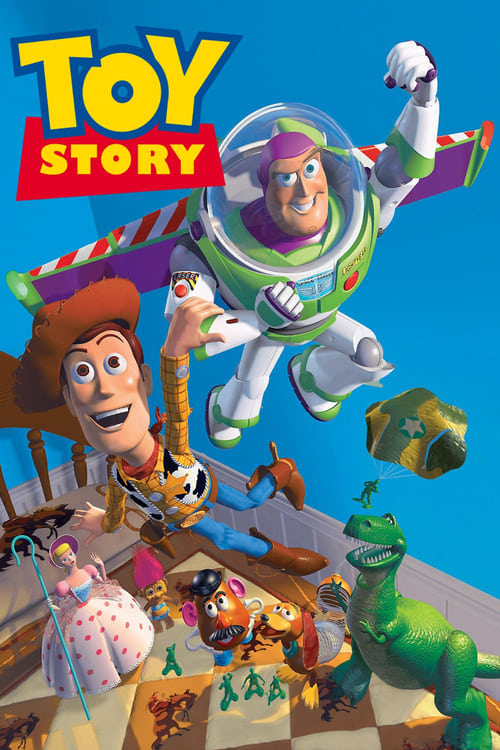

Movie: Toy Story 2 (tmdbId: 863)


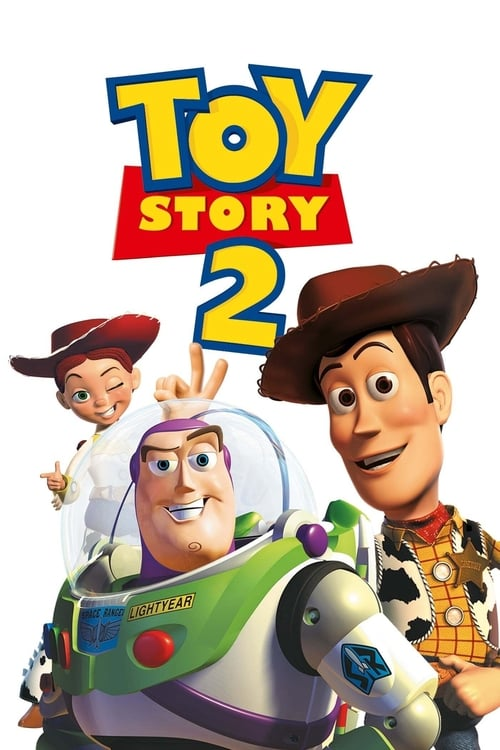

Movie: Toy Story 3 (tmdbId: 10193)


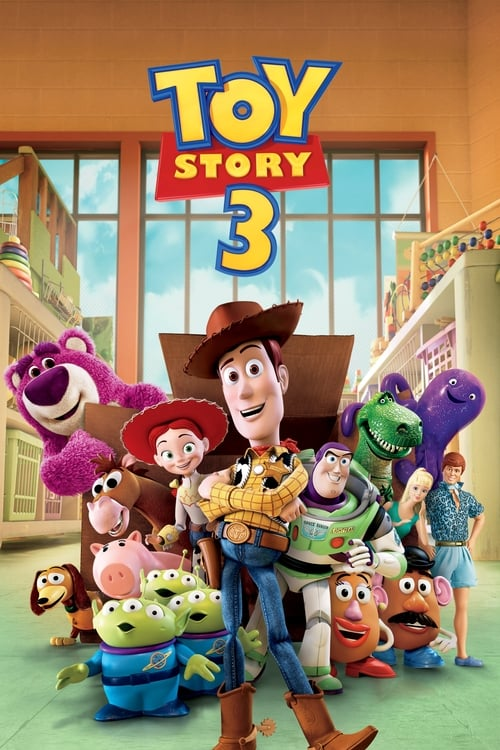

Movie: Toy Soldiers (tmdbId: 10750)


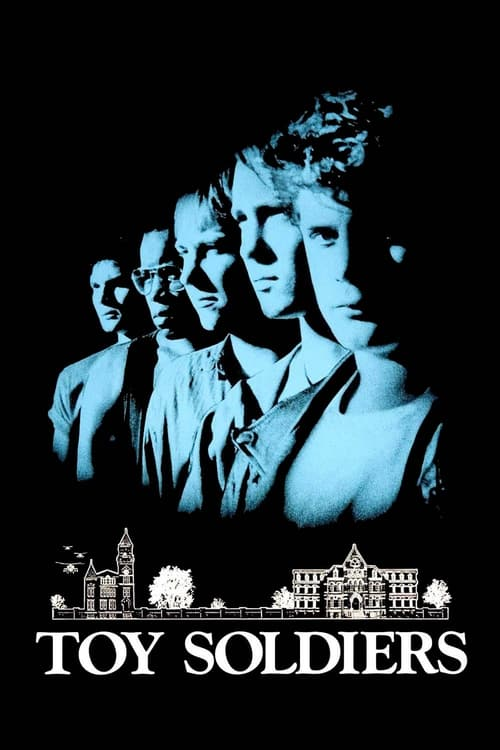

Movie: Toy, The (tmdbId: 23805)


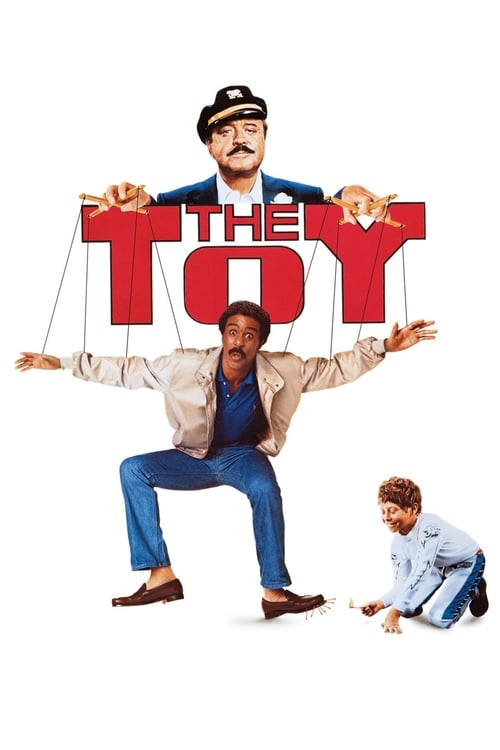

In [17]:
recommendSimilarMoviesWithDetails(10, num_recs=5, q="toy story")

Đây là hàm gợi ý cho user từ những lượt rating của users

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\3657853787.py:7: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  response = es.search(index=ratings, q="userId:{}".format(the_id), size=num, sort=["rating:desc"])
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\3657853787.py:10: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  movies = es.mget(body={"ids": ids}, index=movies, _source_includes=['tmdbId', 'title'])


Movie: Clueless (tmdbId: 9603)


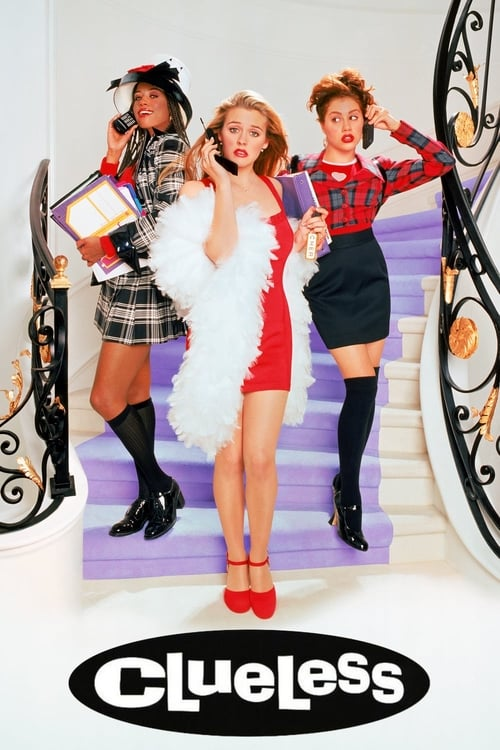

Movie: Star Wars: Episode IV - A New Hope (tmdbId: 11)


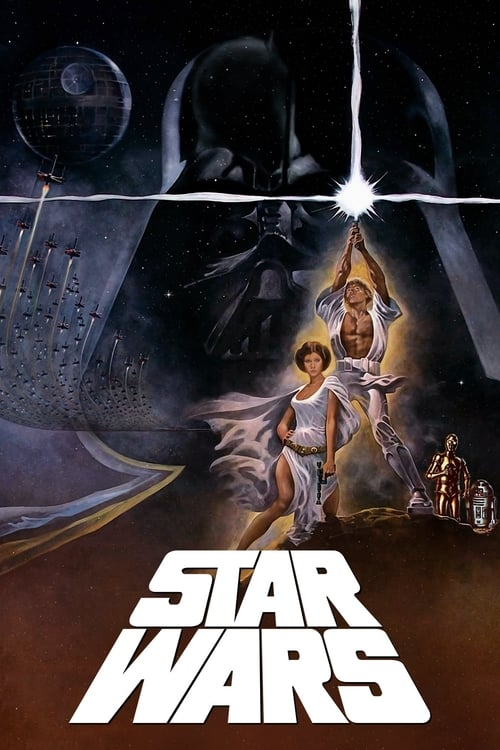

Movie: Pulp Fiction (tmdbId: 680)


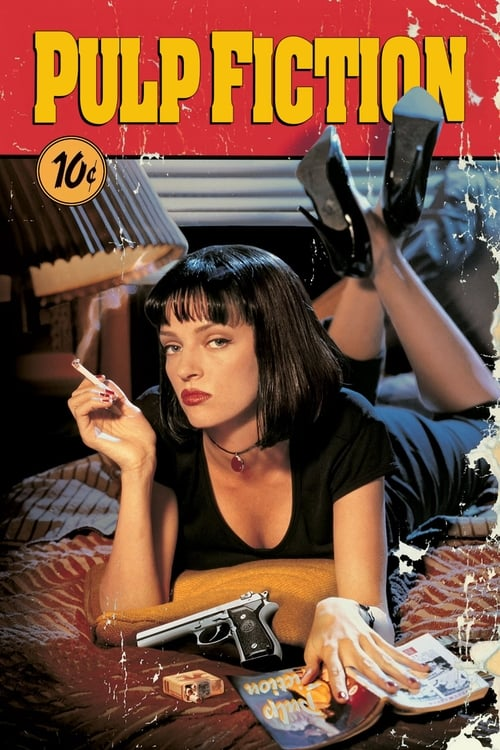

Movie: Shawshank Redemption, The (tmdbId: 278)


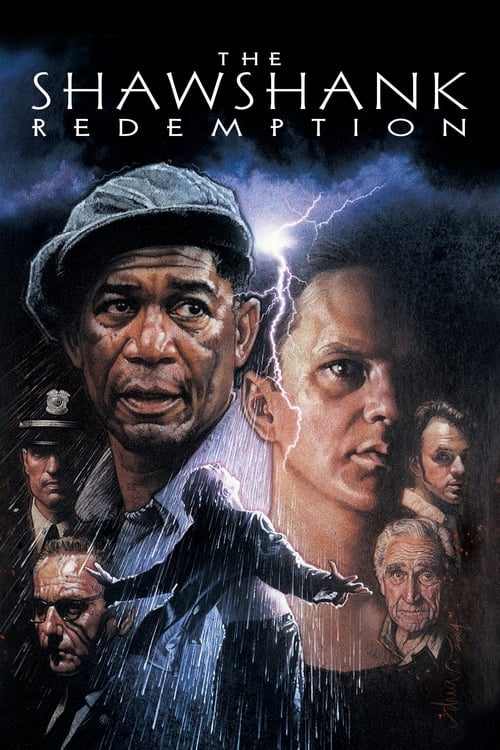

Movie: Dazed and Confused (tmdbId: 9571)


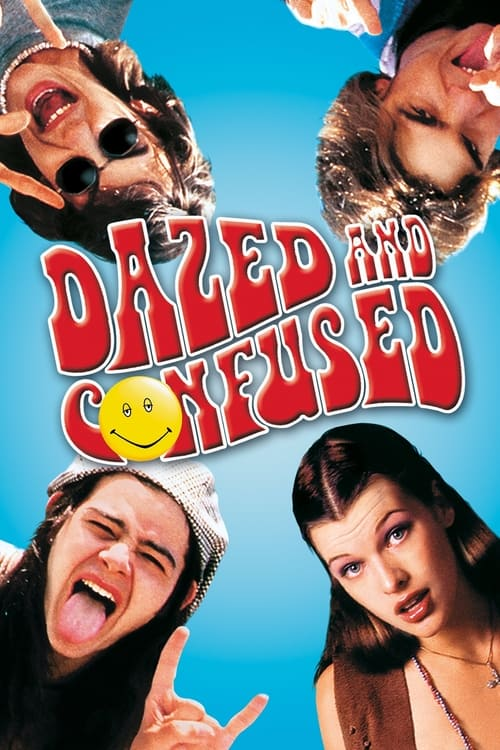

In [18]:
getMoviesRatedByUser(200, num_movies=5)

Đây là hàm gợi ý những phim có rating cao nhất của user

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\3657853787.py:104: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  result = es.search(index="ratings", body=query)
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_5284\3657853787.py:110: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  movie_info = es.get(index="movies", id=movie_id)


Movie: Heat (tmdbId: 949)


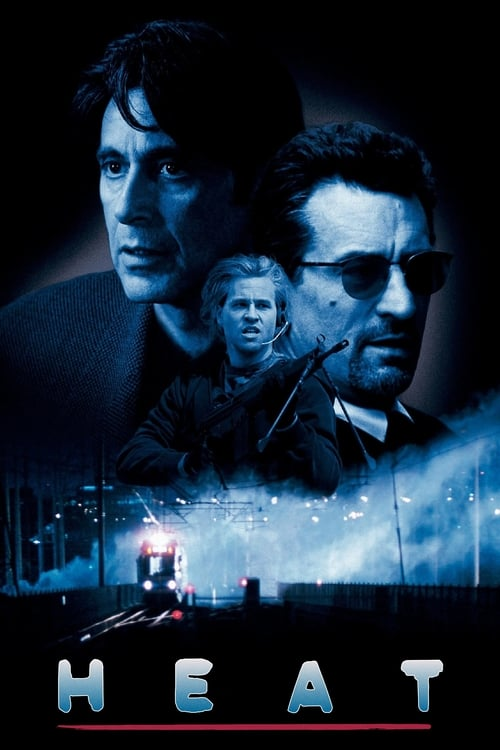

Movie: Casino (tmdbId: 524)


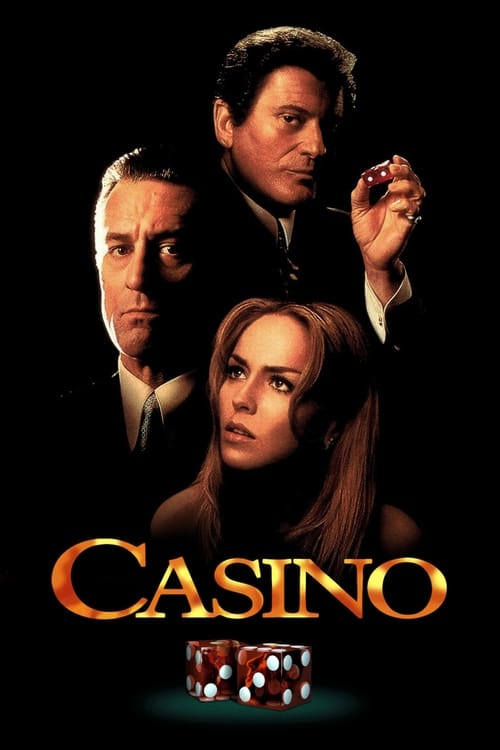

Movie: Twelve Monkeys (a.k.a. 12 Monkeys) (tmdbId: 63)


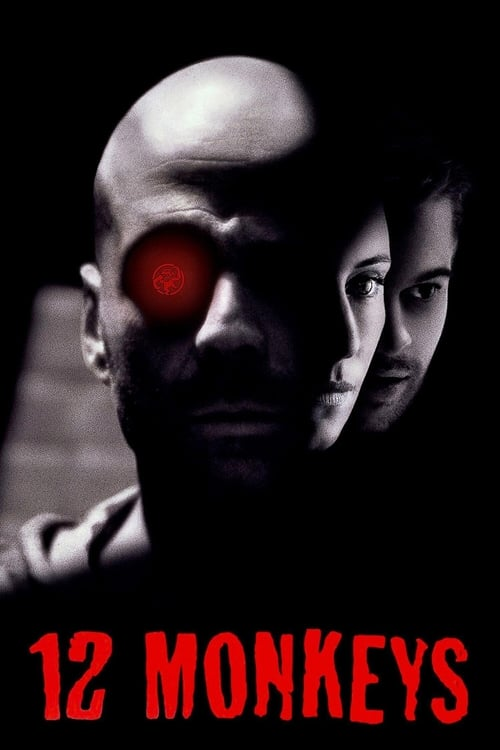

Movie: Seven (a.k.a. Se7en) (tmdbId: 807)


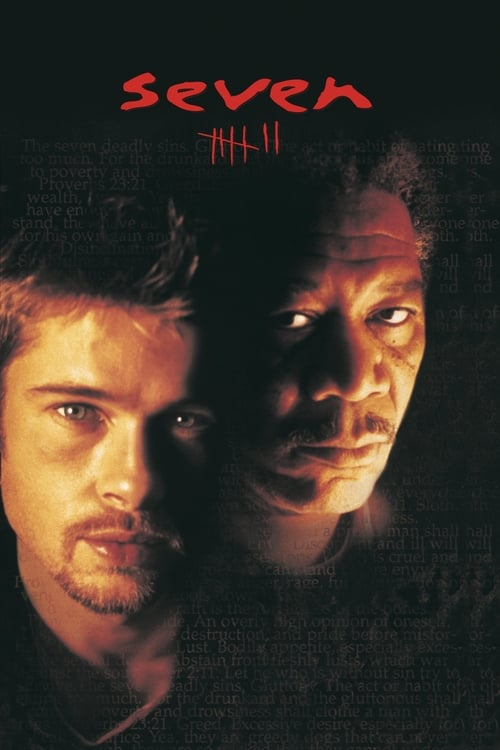

Movie: Usual Suspects, The (tmdbId: 629)


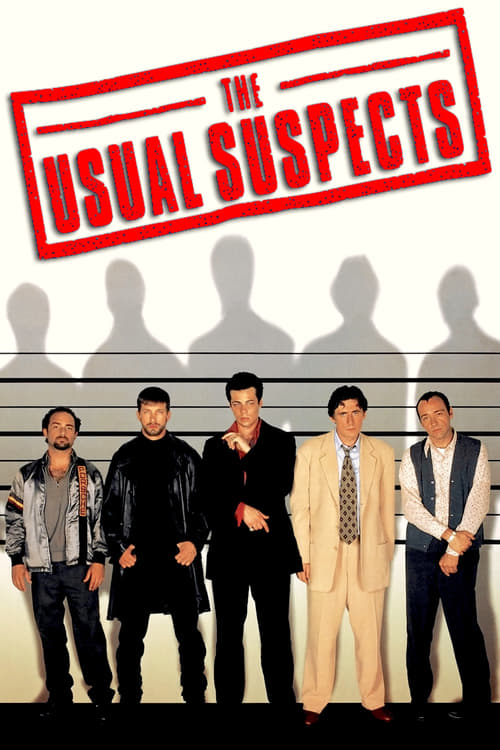

In [19]:
recommendMoviesForUser(105, num_recs=5)

Em xin kết thúc ạ.